In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import jax
import jax.numpy as jnp
from evosax import CMA_ES, SimAnneal

from envs.photon_langevin_env import BatchedPhotonLangevinReadoutEnv

In [3]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 4.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [4]:
env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [5]:
# Instantiate the search strategy
rng = jax.random.PRNGKey(0)
strategy = CMA_ES(popsize=batchsize, num_dims=env.num_actions, elite_ratio=0.5)
es_params = strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)
es_params

EvoParams(mu_eff=Array(17.62165241, dtype=float64), c_1=Array(0.00029451, dtype=float64), c_mu=Array(0.00454011, dtype=float64), c_sigma=Array(0.18935861, dtype=float64), d_sigma=Array(1.18935861, dtype=float64), c_c=Array(0.04936556, dtype=float64), chi_n=Array(8.97228754, dtype=float64, weak_type=True), c_m=1.0, sigma_init=1.0, init_min=-1, init_max=1, clip_min=-2.3255813953488373, clip_max=2.3255813953488373)

In [6]:
# Simulated Annealing

sim_anneal = SimAnneal(popsize=batchsize, num_dims=env.num_actions)
sim_params = sim_anneal.default_params
sim_params = sim_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)

In [7]:
def custom_rollout(batch_actions):
    res_drive = env.a0 * batch_actions.astype(jnp.float64)
    normalizing_factor = jnp.clip(
        env.mu * env.a0 / jnp.absolute(res_drive),
        0.0,
        1.0,
    )
    res_drive *= normalizing_factor
    res_drive = env.batched_smoother(res_drive)

    batch_res = env.batched_results(res_drive)
    reward, _ = env.batched_reward_and_state(
        batch_res.astype(env.float_dtype), res_drive
    )

    fitness = -reward # Since we are dealing with minimisation

    return fitness.astype(jnp.float32)

In [8]:
import time

state = sim_anneal.initialize(rng, sim_params)

start = time.time()
fitness_list = []

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(int(2e4)):
    rng, rng_gen, rng_eval = jax.random.split(rng, 3)
    x, state = sim_anneal.ask(rng_gen, state, sim_params)
    fitness = custom_rollout(x)
    state = sim_anneal.tell(x, fitness, state, sim_params)
    fitness_list.append(state.best_fitness)

    if (t + 1) % 100 == 0:
        # print("CMA-ES - # Gen: {}|Fitness: {:.5f}|Params: {}".format(
        #     t+1, state.best_fitness, state.best_member))
        print("CMA-ES - # Gen: {}|Fitness: {:.5f}".format(
            t+1, state.best_fitness))
        print(f"Time: {time.time() - start}")

CMA-ES - # Gen: 100|Fitness: -3.00007
Time: 6.475762844085693
CMA-ES - # Gen: 200|Fitness: -3.28983
Time: 7.599078893661499
CMA-ES - # Gen: 300|Fitness: -3.32854
Time: 8.79961895942688
CMA-ES - # Gen: 400|Fitness: -3.35414
Time: 9.923290967941284
CMA-ES - # Gen: 500|Fitness: -3.35414
Time: 11.048563003540039
CMA-ES - # Gen: 600|Fitness: -3.35414
Time: 12.172606945037842
CMA-ES - # Gen: 700|Fitness: -3.35414
Time: 13.358442068099976
CMA-ES - # Gen: 800|Fitness: -3.35414
Time: 14.494289875030518
CMA-ES - # Gen: 900|Fitness: -3.35414
Time: 15.668645858764648
CMA-ES - # Gen: 1000|Fitness: -3.35414
Time: 16.862222909927368
CMA-ES - # Gen: 1100|Fitness: -3.35414
Time: 17.975238800048828
CMA-ES - # Gen: 1200|Fitness: -3.35414
Time: 19.216197967529297
CMA-ES - # Gen: 1300|Fitness: -3.35414
Time: 20.440404891967773
CMA-ES - # Gen: 1400|Fitness: -3.35414
Time: 21.656872987747192
CMA-ES - # Gen: 1500|Fitness: -3.35414
Time: 22.784487009048462
CMA-ES - # Gen: 1600|Fitness: -3.35414
Time: 23.903316

KeyboardInterrupt: 

[-2.32464717 -2.3255814  -2.3255814  -2.30655108 -2.31580105 -2.32107798
 -2.3255814  -2.3255814  -2.3255814  -2.25445362 -2.28596481 -2.3255814
 -2.2598812  -2.3026897  -2.06466552 -2.27383403 -2.05522441 -2.1017188
 -1.85009256 -1.75569985 -1.99829887 -1.67560853 -1.46857531 -1.70624883
 -1.2284881  -1.26518633 -1.36316167 -0.92569586 -1.44488707 -0.67295207
 -1.67212888 -0.6496449  -1.33405538 -0.56631018 -0.69046028  0.18663844
  0.32012163  1.51924009  1.25018673  2.23926357  2.10893003  2.2895153
  2.3255814   2.3255814   2.30147672  2.30600227  2.31439866  2.3255814
  2.3255814   2.32155537  2.2896211   2.32186365  1.94305065  2.10992679
  1.75116862  1.15695654  1.43801938  0.34241563  0.78513501 -0.23622559
  0.03624933 -0.90341173 -0.50432038 -1.67129817 -1.1147173  -2.13045889
 -1.25082028 -2.16868366 -1.1871362  -1.68913003 -1.03098854 -1.54548589
 -1.16888077 -1.26283275 -1.48828355 -0.96986677 -1.45410587 -0.7793237
 -1.56115945 -0.08814277 -1.70055953]


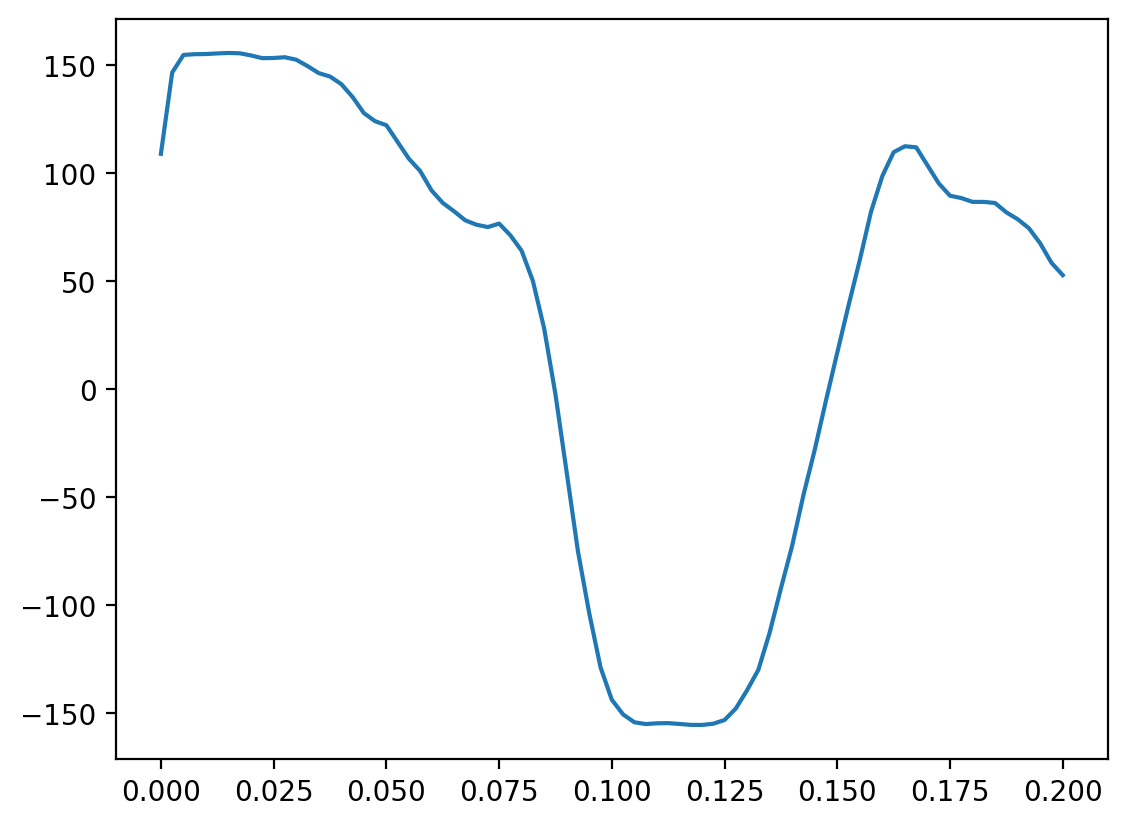

In [9]:
import matplotlib.pyplot as plt

action = state.best_member
action *= env.a0
action = -env.drive_smoother(action)

print(state.best_member)
plt.plot(env.ts_action, action)
plt.show()

In [10]:
batched_action = jnp.tile(action, (batchsize, 1))

batched_res = env.batched_results(batched_action)
(
    max_pf,
    max_photons,
    photon_reset_time,
    pulse_end_times,
    max_pf_times,
    smoothness_vals,
    b_pf,
    b_higher_photons,
) = env.batched_extract_values(batched_res, batched_action)

reward, _ = env.batched_reward_and_state(
    batched_res,
    batched_action
)

print(max_pf_times[0])
print(photon_reset_time[0])
print(reward[0])

0.0961111111111111
0.1688888888888889
24.000044322524992


0.08688947438050176
304
0.1980258200961999
299


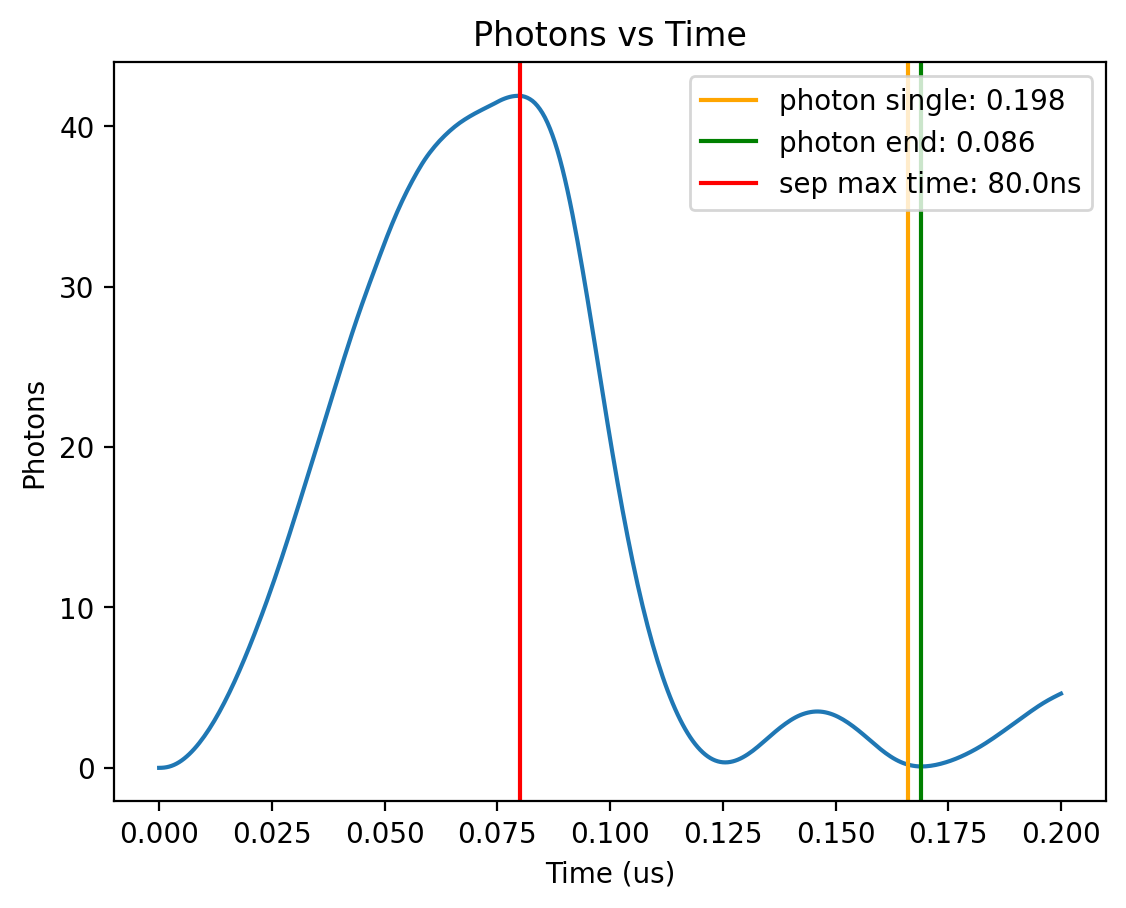

In [11]:
single_photon = b_higher_photons[0]

single_res = batched_res[0]
g_real, g_imag, e_real, e_imag = single_res.T
single_sep = jnp.sqrt((g_real - g_imag) ** 2 + (e_real - e_imag) ** 2)

single_photon = g_real ** 2 + g_imag ** 2

ext = 50
ext_15 = 300
ext_2 = -1

min_photon = jnp.min(single_photon[ext:ext_2])
argmin = jnp.argmin(single_photon[ext:ext_2]) + ext

min_photon_2 = jnp.min(single_photon[ext:ext_15])
argmin_2 = jnp.argmin(single_photon[ext:ext_15]) + ext

argmax = jnp.argmax(single_sep)

print(min_photon)
print(argmin)

print(min_photon_2)
print(argmin_2)

plt.plot(env.ts_sim, single_photon)
plt.axvline(x=env.ts_sim[argmin_2], label=f'photon single: {int(1e3*min_photon_2)/1e3}', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'photon end: {int(1e3*min_photon)/1e3}', color='green')
plt.axvline(x=env.ts_sim[argmax], label=f'sep max time: {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.xlabel('Time (us)')
plt.ylabel('Photons')
plt.title('Photons vs Time')
plt.legend()
plt.show()

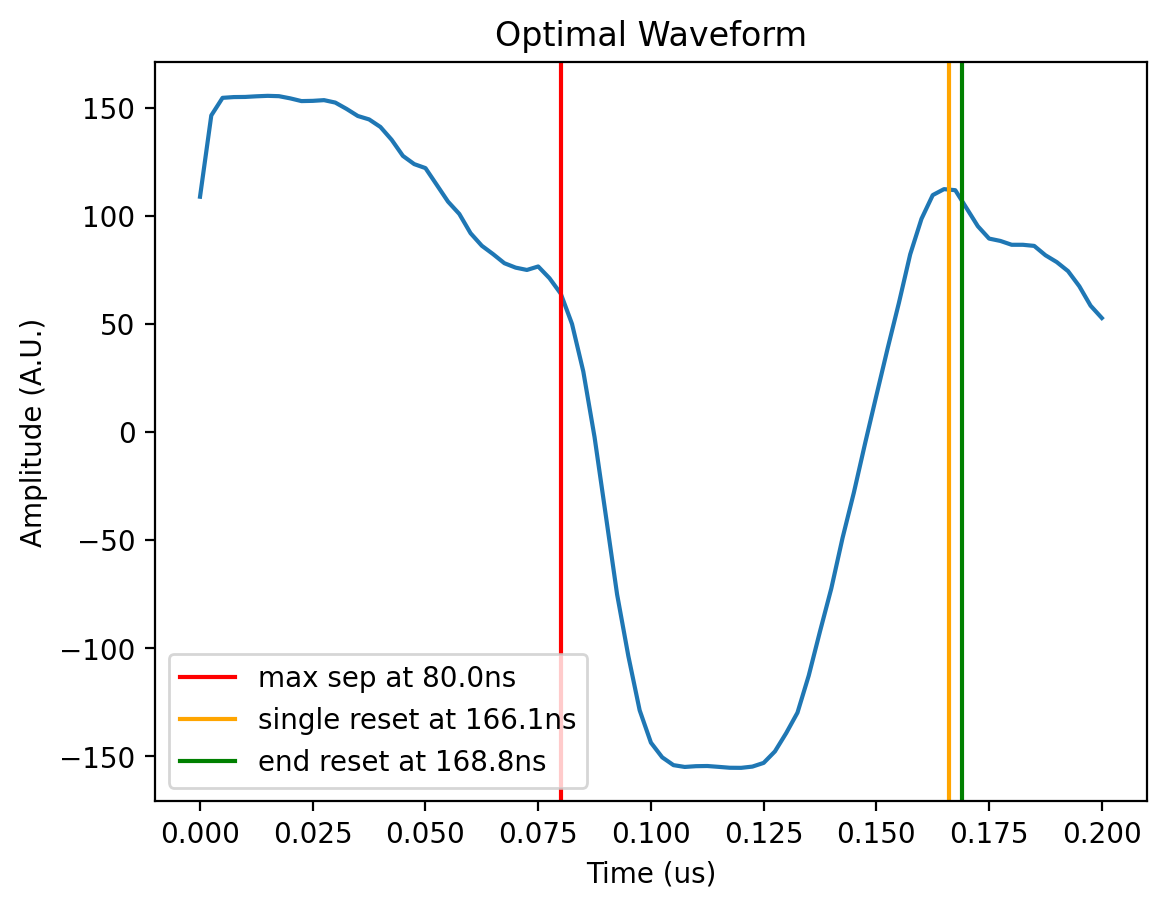

In [12]:
plt.plot(env.ts_action, action)
plt.axvline(x=env.ts_sim[argmax], label=f'max sep at {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.axvline(x=env.ts_sim[argmin_2], label=f'single reset at {int(1e4*env.ts_sim[argmin_2])/1e1}ns', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'end reset at {int(1e4*env.ts_sim[argmin])/1e1}ns', color='green')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.title('Optimal Waveform')
plt.legend()
plt.show()

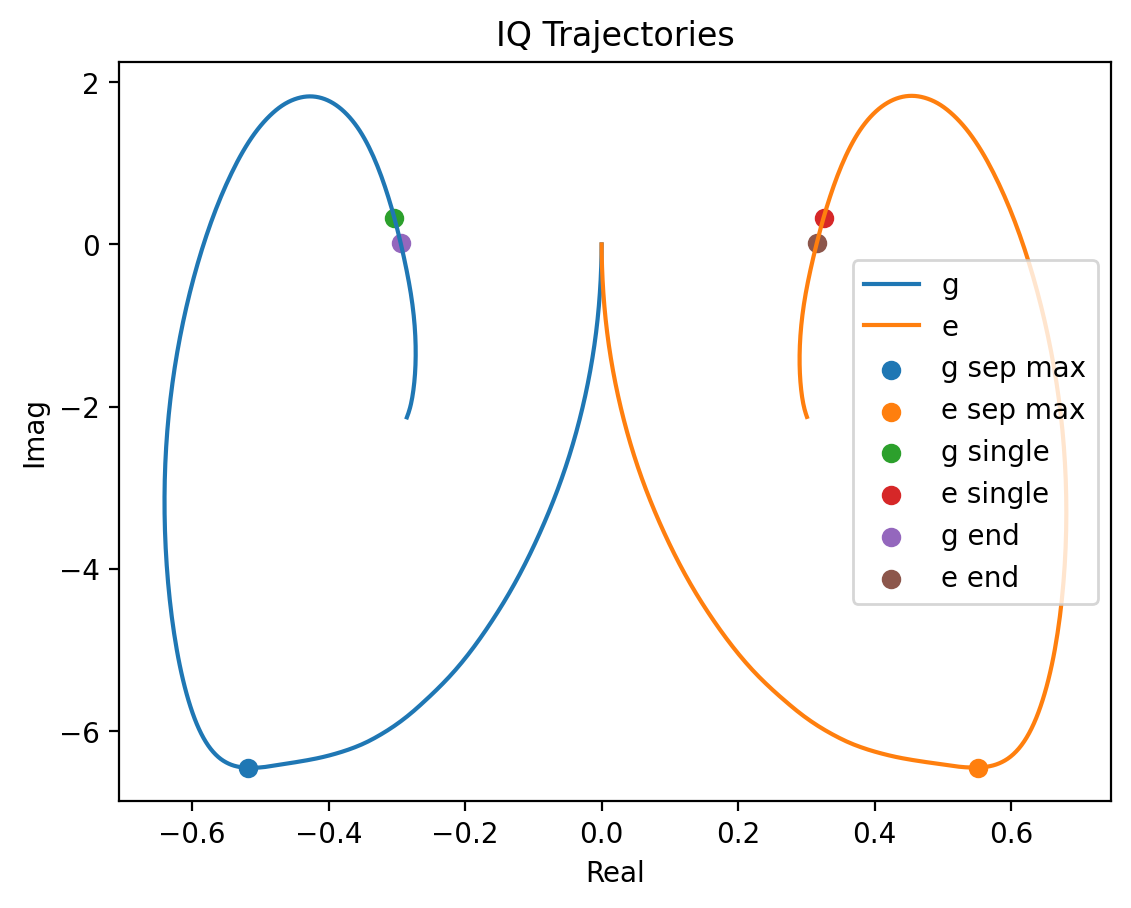

In [13]:
plt.plot(g_real, g_imag, label='g')
plt.plot(e_real, e_imag, label='e')
plt.scatter(g_real[argmax], g_imag[argmax], label='g sep max')
plt.scatter(e_real[argmax], e_imag[argmax], label='e sep max')
plt.scatter(g_real[argmin_2], g_imag[argmin_2], label='g single')
plt.scatter(e_real[argmin_2], e_imag[argmin_2], label='e single')
plt.scatter(g_real[argmin], g_imag[argmin], label='g end')
plt.scatter(e_real[argmin], e_imag[argmin], label='e end')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('IQ Trajectories')
plt.legend()
plt.show()

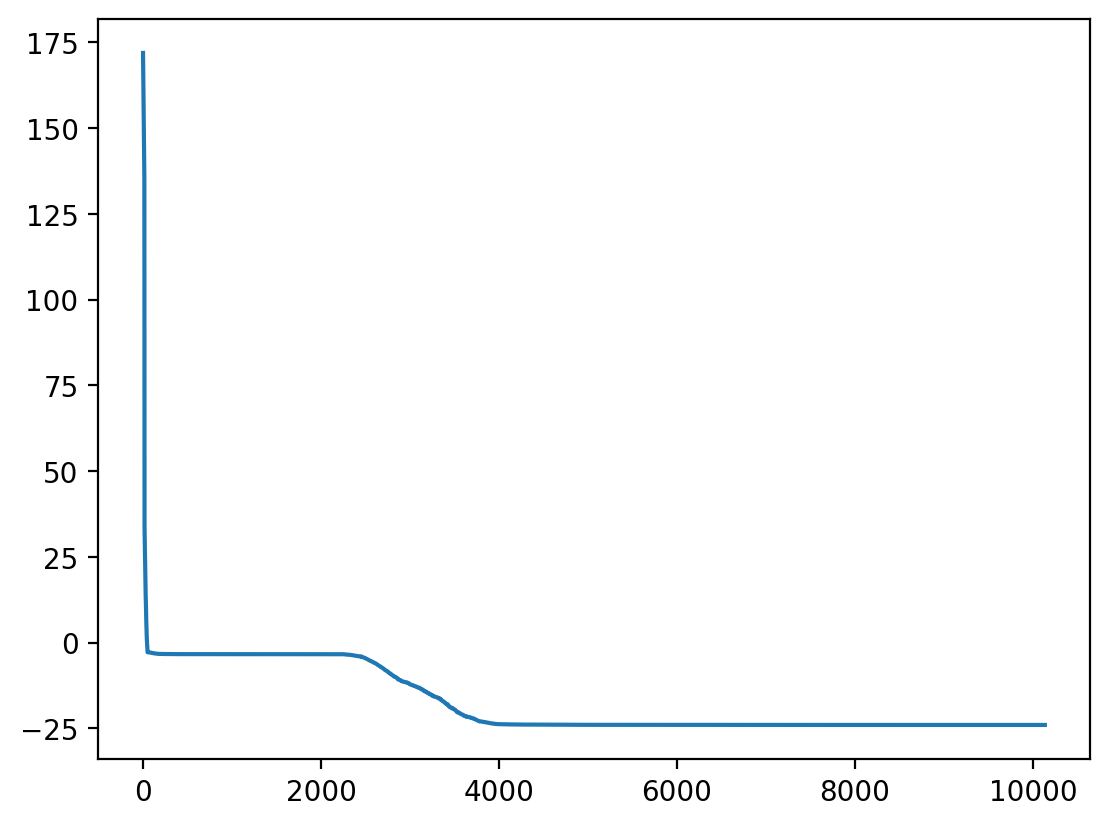

In [14]:
plt.plot(fitness_list)